In [1]:
import scipy
import fitsio
import smatch
import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import hpgeom
import numba
import tqdm

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
_ed = fitsio.read("des_exposure_data.fits")

In [3]:
_ed = np.sort(_ed, order="mjd_obs")

In [4]:
_ed.shape

(100802,)

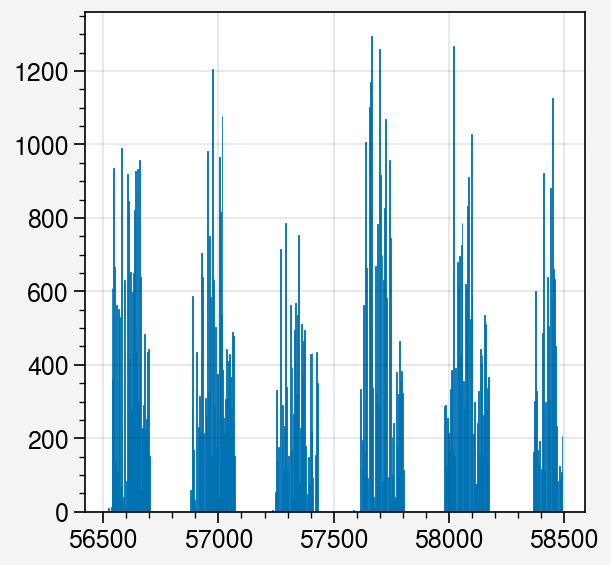

In [5]:
fig, axs = pplt.subplots()

axs.hist(_ed["mjd_obs"], bins=500);

In [6]:
from silly_cal.models import nights_with_mirror

nside = 1024
nside = 128

bmsk = (_ed["band"] == "r") | (_ed["band"] == "r")
fd = nights_with_mirror.gen_fake_data(
    # edata=_ed[bmsk],
    # edata=_ed[(_ed["mjd_obs"] < 57200) & bmsk],
    edata=_ed[(_ed["mjd_obs"] > 57900) & bmsk],
    # edata=_ed[(_ed["mjd_obs"] > 57500) & (_ed["mjd_obs"] < 58300) & bmsk],
    nside=nside,
    seed=None,
    target_nstar=20e6,
    period=365,
)

<a list of 1 Line2D objects>

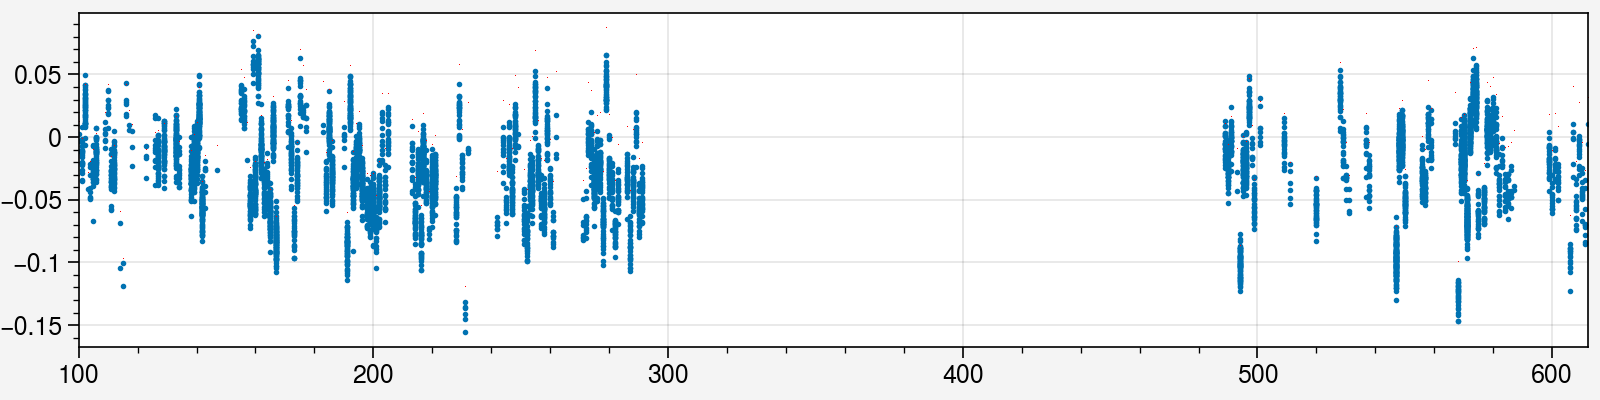

In [7]:
fig, axs = pplt.subplots(figsize=(8, 2))

axs.plot(fd["data"]["night"], fd["data"]["true_zp"], ".", markersize=2)
yv = fd["data"]["true_zp_night"][fd["data"]["inv_unight"]]
axs.plot(fd["data"]["night"], yv, ",", color="r")

# axs.format(ylim=(-1.5, 0.2), xlim=(0, 50))

## Optimize the Loss

In [8]:
# from silly_cal.optimizers import run_amsgrad, run_laprop

# from functools import partial

# pars = nights_with_mirror.gen_guess(fd["opt_kwargs"], eps=1e-2)
# grad = np.zeros_like(pars)
# nt = numba.get_num_threads()
# tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

# def ofun(pars):
#     return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])

# ores = run_laprop(ofun, pars, 1e-3, 10000)
# ores

In [9]:
from scipy.optimize import minimize
from functools import partial

pars = nights_with_mirror.gen_guess(fd["opt_kwargs"], eps=1e-2)
grad = np.zeros_like(pars)
nt = numba.get_num_threads()
tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

def ofun(pars):
    return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[0]

def ofun_jac(pars):
    return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[1].copy()

res = minimize(
    ofun, pars, method="L-BFGS-B", jac=ofun_jac, options=dict(disp=10),
)
res = minimize(
    ofun, res["x"], method="L-BFGS-B", jac=ofun_jac, options=dict(disp=10),
)
res

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        31833     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18451D+02    |proj g|=  2.21581D+02

At iterate   10    f=  1.67076D+01    |proj g|=  1.64348D+01

At iterate   20    f=  6.45776D+00    |proj g|=  1.09793D+01


 This problem is unconstrained.



At iterate   30    f=  3.67600D+00    |proj g|=  5.29317D+00

At iterate   40    f=  2.40374D+00    |proj g|=  1.40829D+01

At iterate   50    f=  1.49275D+00    |proj g|=  3.35222D+00

At iterate   60    f=  1.15632D+00    |proj g|=  1.82816D+00

At iterate   70    f=  9.45425D-01    |proj g|=  1.66471D+00

At iterate   80    f=  8.67927D-01    |proj g|=  1.46827D+00

At iterate   90    f=  8.21080D-01    |proj g|=  6.03850D-01

At iterate  100    f=  7.91859D-01    |proj g|=  7.08883D-01

At iterate  110    f=  7.69464D-01    |proj g|=  8.91474D-01

At iterate  120    f=  7.51974D-01    |proj g|=  3.27030D-01

At iterate  130    f=  7.40226D-01    |proj g|=  9.64142D-01

At iterate  140    f=  7.29570D-01    |proj g|=  3.33569D-01

At iterate  150    f=  7.19310D-01    |proj g|=  8.80791D-01

At iterate  160    f=  7.13031D-01    |proj g|=  5.39627D-01

At iterate  170    f=  7.07585D-01    |proj g|=  5.02927D-01

At iterate  180    f=  7.03352D-01    |proj g|=  3.07201D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  6.84870D-01    |proj g|=  1.02550D-01

At iterate   20    f=  6.84854D-01    |proj g|=  9.69190D-02

At iterate   30    f=  6.84841D-01    |proj g|=  4.36314D-02

At iterate   40    f=  6.84831D-01    |proj g|=  9.26796D-02

At iterate   50    f=  6.84816D-01    |proj g|=  2.15997D-01

At iterate   60    f=  6.84808D-01    |proj g|=  9.81306D-02

At iterate   70    f=  6.84794D-01    |proj g|=  1.54743D-01

At iterate   80    f=  6.84773D-01    |proj g|=  7.59844D-02

At iterate   90    f=  6.84757D-01    |proj g|=  7.03748D-02

At iterate  100    f=  6.84740D-01    |proj g|=  6.93844D-02

At iterate  110    f=  6.84705D-01    |proj g|=  8.16737D-02

At iterate  120    f=  6.84644D-01    |proj g|=  2.05229D-01

At iterate  130    f=  6.84622D-01    |proj g|=  3.59292D-02

At iterate  140    f=  6.84602D-01    |proj g|=  1.75030D-01

At iterate  150    f=  6.84589D-01    |proj g|=  4.60570D-02

At iterate  160    f=  6.84570D-01    |proj g|=  7.98382D-02

At iter

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.684519090674272
        x: [-1.603e-01 -1.710e-01 ...  1.745e-04  3.796e-03]
      nit: 208
      jac: [ 6.091e-02 -2.570e-03 ...  1.071e-04  9.717e-05]
     nfev: 245
     njev: 245
 hess_inv: <31833x31833 LbfgsInvHessProduct with dtype=float64>

In [10]:
fdd = fd["data"]

In [11]:
fdd["true_tel_eff"], res["x"][0:fdd["true_tel_eff"].shape[0]]

(array([-0.14948979, -0.15838316]), array([-0.16031244, -0.17096055]))

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import healsparse as hsp

import skyproj

In [13]:
hmap = hsp.HealSparseMap.make_empty(32, nside, np.float64)

In [14]:
est_star = res["x"][fd["opt_kwargs"]["nyear"] + fd["opt_kwargs"]["nnight"]+fd["opt_kwargs"]["nexp"]:]

dstar = (est_star - fdd["true_star"]) * 1e3

hmap.update_values_pix(fdd["true_star_nest_ind"], dstar)

In [15]:
from mattspy.stats import mad

fac = np.sqrt(fd["params"]["target_nstar"] / dstar.shape[0])

np.mean(dstar), mad(dstar), mad(dstar) * fac

(-0.005232816523452171, 2.2155033829462334, 62.727913769352384)

In [16]:
def get_true_zp(fd):
    rho_night = fd["params"]["rho_night"]
    true_zp_night = fd["data"]["true_zp_night"]
    true_zp_nse = fd["data"]["true_zp_nse"]
    true_tel_eff = fd["data"]["true_tel_eff"]
    night_in_year = fd["data"]["night_in_year"]
    inv_unight = fd["data"]["inv_unight"]
    inv_uyear = fd["data"]["inv_uyear"]
    
    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    return (
        sqrt_rho_night * true_zp_night[inv_unight]
        + rho_night_fac * true_zp_nse
        + true_tel_eff[inv_uyear] * night_in_year
    )


def get_est_zp(pars, fd):
    nnight = fd["data"]["true_zp_night"].shape[0]
    nexp = fd["data"]["true_zp_nse"].shape[0]
    nyear = fd["data"]["true_tel_eff"].shape[0]
    
    tel_eff = pars[0:nyear]
    zp_night = pars[nyear:nyear+nnight]
    zp_nse = pars[nyear+nnight:nyear+nnight+nexp]

    rho_night = fd["params"]["rho_night"]
    
    night_in_year = fd["data"]["night_in_year"]
    inv_unight = fd["data"]["inv_unight"]
    inv_uyear = fd["data"]["inv_uyear"]
    
    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    return (
        sqrt_rho_night * zp_night[inv_unight]
        + rho_night_fac * zp_nse
        + tel_eff[inv_uyear] * night_in_year
    )

true_zp = get_true_zp(fd)
est_zp = get_est_zp(res["x"], fd)

dzp = (est_zp - true_zp) * 1e3

from mattspy.stats import mad

np.mean(dzp), mad(dzp)

(0.03241879516794528, 1.5214230593394613)

In [17]:
_nside = 32

exp_hmap = hsp.HealSparseMap.make_empty(32, _nside, np.float64)
nexp_hmap = hsp.HealSparseMap.make_empty(32, _nside, np.float64)

exp_hmap.update_values_pos(fd["data"]["exp_ra"], fd["data"]["exp_dec"], dzp, operation="add")
nexp_hmap.update_values_pos(fd["data"]["exp_ra"], fd["data"]["exp_dec"], 1.0, operation="add")

exp_hmap_vals = exp_hmap.get_values_pix(exp_hmap.valid_pixels)
nexp_hmap_vals = nexp_hmap.get_values_pix(nexp_hmap.valid_pixels)

exp_hmap_vals /= nexp_hmap_vals

_ra, _dec = exp_hmap.valid_pixels_pos()

mn_exp_hmap = hsp.HealSparseMap.make_empty(32, _nside, np.float64)
mn_exp_hmap.update_values_pos(_ra, _dec, exp_hmap_vals)

(<matplotlib.colorbar.Colorbar at 0x141b89900>,
 <AxesHostAxes:xlabel='exposure $\\Delta mag$ [mmag]'>)

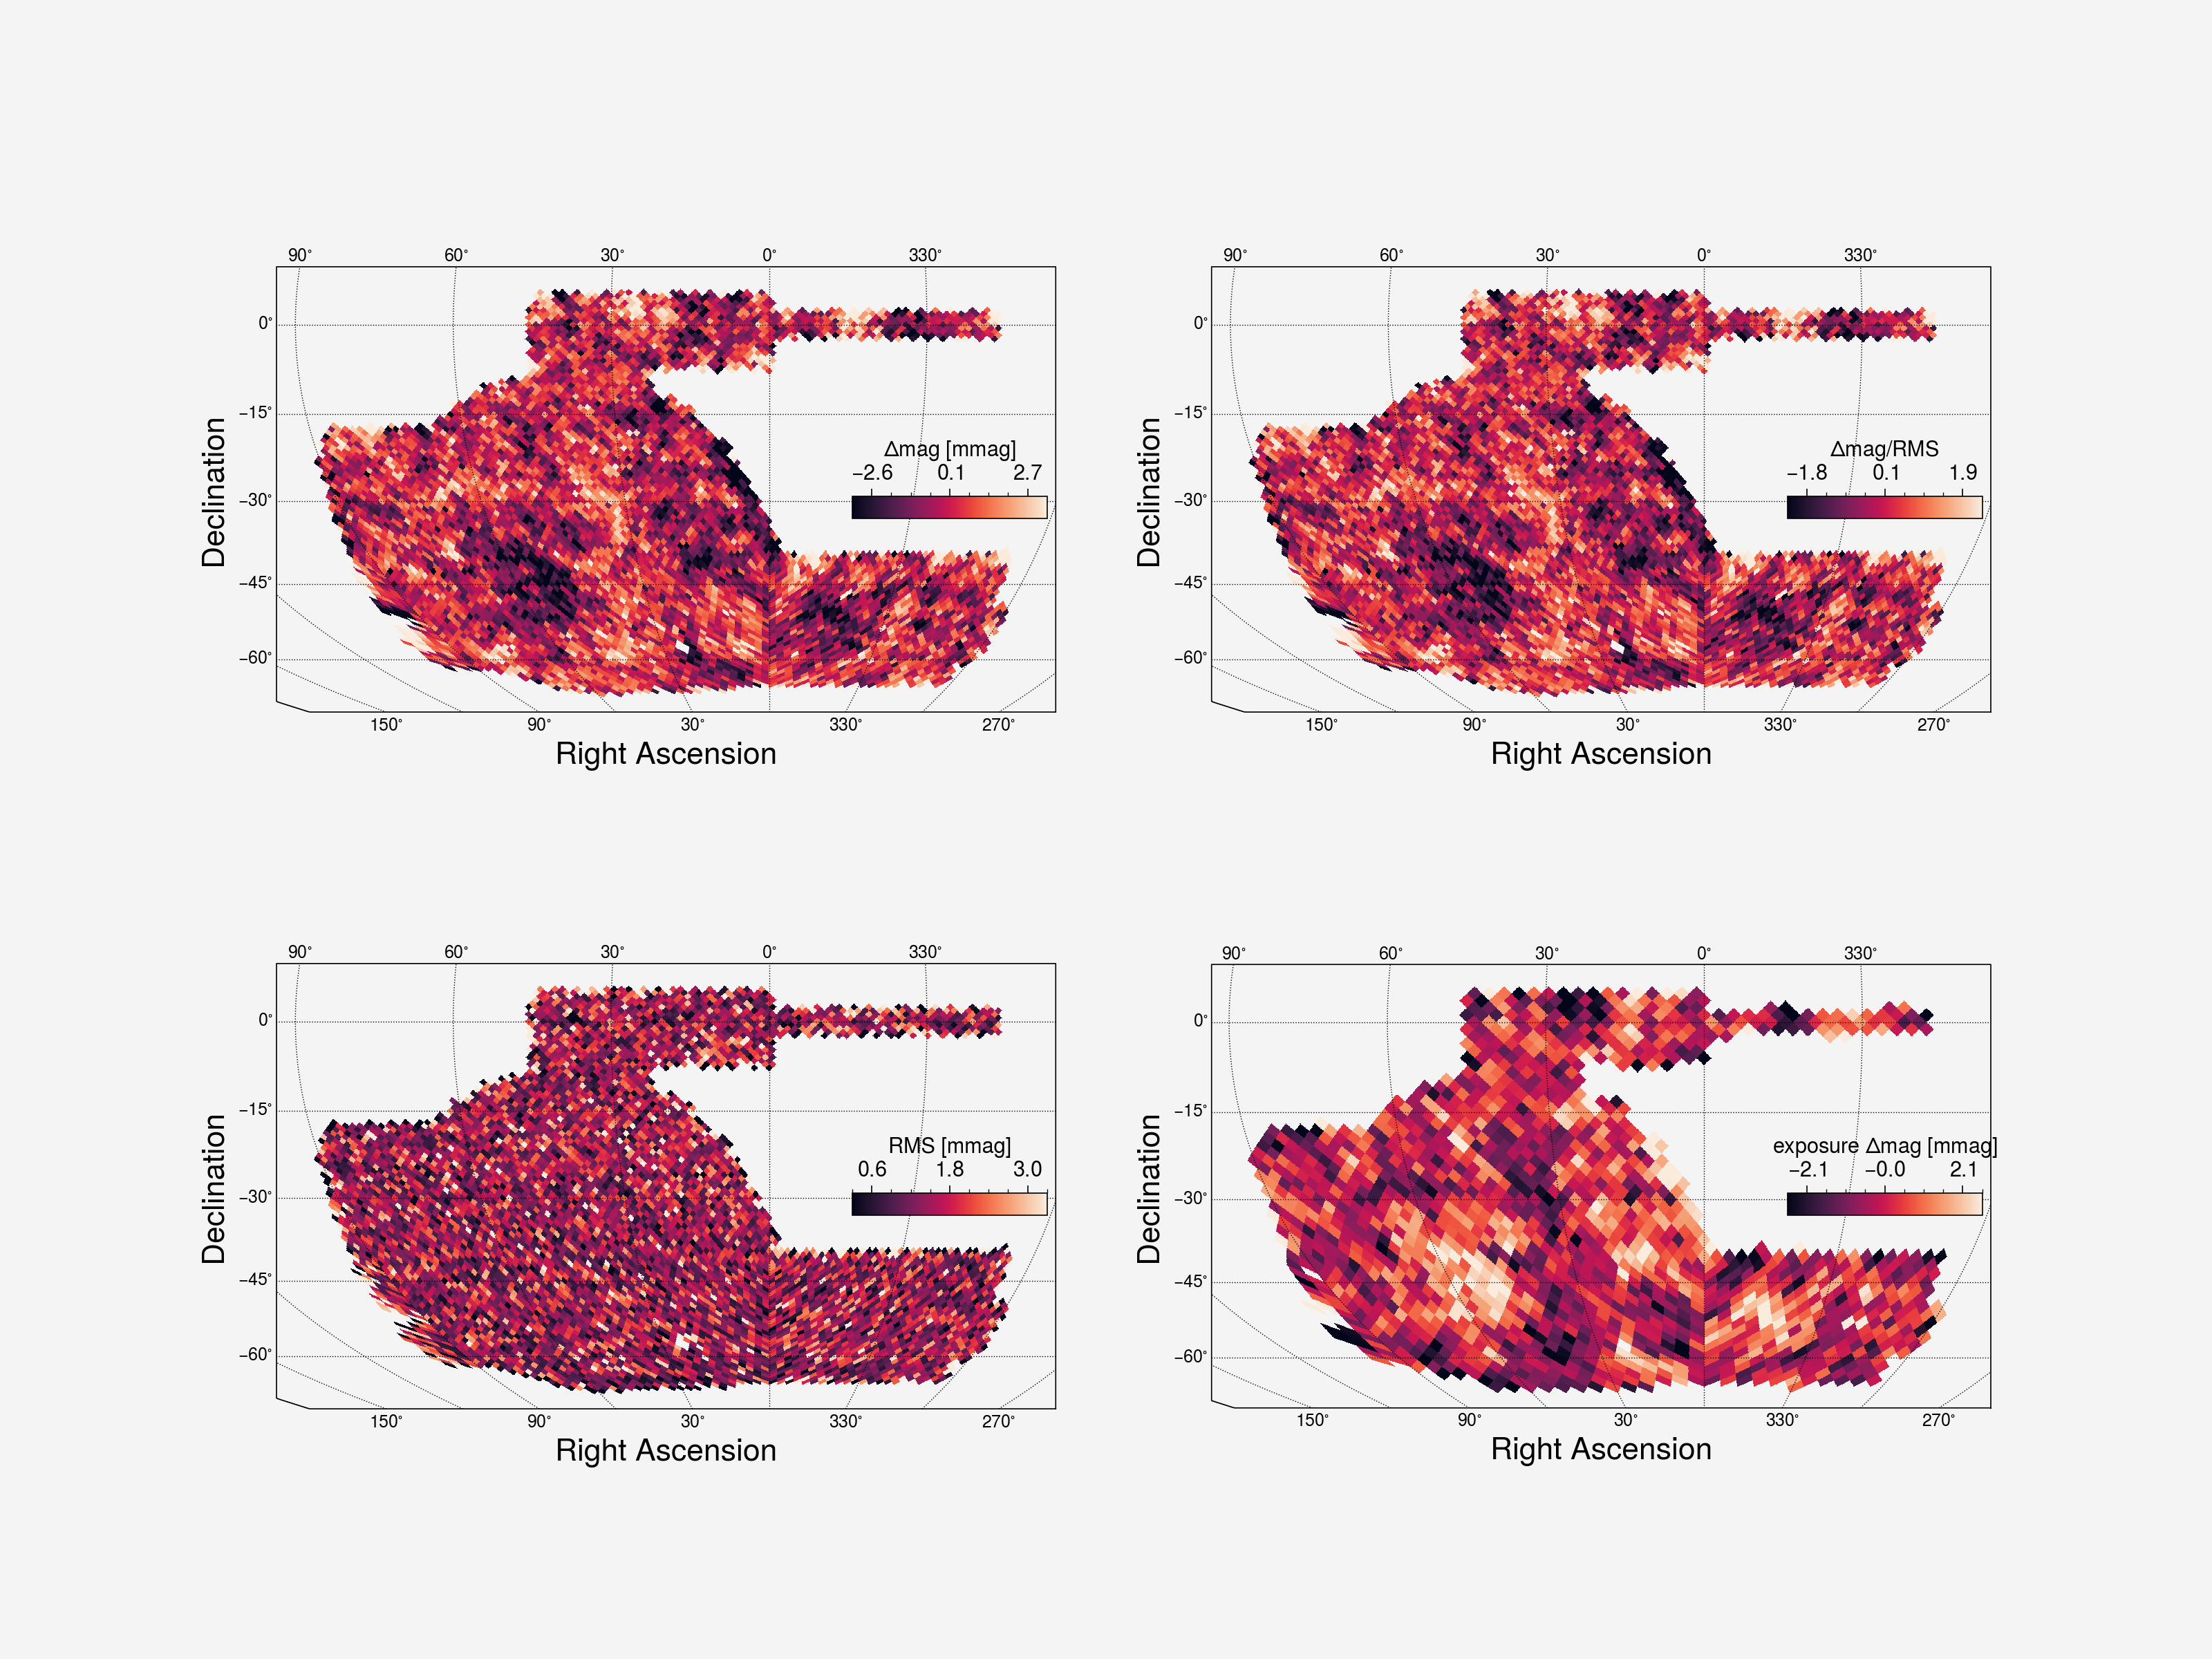

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 12), squeeze=False)

mn_map = hmap.degrade(64, reduction="mean")
sd_map = hmap.degrade(64, reduction="std")
mean_sd = np.median(sd_map.get_values_pix(sd_map.valid_pixels))

sp = skyproj.McBrydeSkyproj(ax=axs[0, 0])
sp.draw_hspmap(mn_map, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag$ [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[0, 1])
sp.draw_hspmap(mn_map / mean_sd, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag/RMS$")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
sp.draw_hspmap(sd_map, cmap="rocket")
sp.draw_inset_colorbar(label="RMS [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 1])
sp.draw_hspmap(mn_exp_hmap, cmap="rocket")
sp.draw_inset_colorbar(label="exposure $\Delta mag$ [mmag]")